In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import string
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder
from textblob import TextBlob

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
df_input = pd.read_csv("../data/raw/train.csv")
print(df_input.shape)
df_input.head()

(16784, 30)


,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,73000.0,45330.0,50462.0,NaN,NaN,uncategorized,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",NaN,71300.0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,110112.0,27502.0,1376.0,NaN,25-jan-2035,uncategorized,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,NaN,43800.0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,80000.0,27886.0,26041.0,NaN,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,NaN,95500.0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,9800.0,46412.0,56977.0,NaN,NaN,uncategorized,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,NaN,197900.0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,40000.0,20072.0,20101.0,NaN,NaN,uncategorized,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",NaN,103200.0


# Overview
- text variables
- categorical variables
- time variables
- numerical variables

# Variable Types

In [3]:
target = "price"

In [4]:
cat_vars = [var for var in df_input.columns if df_input[var].dtype == 'O']
cat_vars = cat_vars + ['listing_id']
print (f"length of categorical variables: {len(cat_vars)}")
print (f"categorical variable names: {cat_vars}")
# "original_reg_date", "reg_date", "lifespan" are misclassified, they should belong to date


length of categorical variables: 16
categorical variable names: ['title', 'make', 'model', 'description', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'fuel_type', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'listing_id']


In [5]:
time_vars = ["original_reg_date", "reg_date", "lifespan", 'manufactured']
for i in time_vars:
    if i in cat_vars:
        cat_vars.remove(i)

In [6]:
df_input[cat_vars] = df_input[cat_vars].astype('O')

In [7]:
num_vars = [
    var for var in df_input.columns if var not in cat_vars+time_vars and var != target
]

print (f"length of numerical variables: {len(num_vars)}")
print (f"numerical variable names: {num_vars}")

length of numerical variables: 12
numerical variable names: ['curb_weight', 'power', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'indicative_price']


# Text Variables

[description, accessories, features, title, category]
1. add target encoding for `category` column
2. add basic text features to [description, accessories, features]
3. explore sentiment analysis, TF-IDF, universal encoder

In [8]:
df_input[["description", "accessories", "features", "title", "category"]].head(5)

,description,accessories,features,title,category
0,1 owner! 320i gt m-sports model! big brake kit...,"bmw i-drive, navigation, bluetooth/aux/usb inp...","5 doors gt, powerful and fuel efficient 2.0l t...",BMW 3 Series 320i Gran Turismo M-Sport,"parf car, premium ad car, low mileage car"
1,high loan available! low mileage unit. wear an...,factory radio setting. front recording camera....,low mileage unit. well maintained vehicle. vie...,Toyota Hiace 3.0M,premium ad car
2,1 owner c&c unit. full agent service with 1 mo...,dual electric/memory seats. factory fitted aud...,responsive and fuel efficient 1.6l inline 4 cy...,Mercedes-Benz CLA-Class CLA180,"parf car, premium ad car"
3,"fully agent maintained, 3 years warranty 10 ye...",64 colour ambient lighting. active parking ass...,"1.5l inline-4 twin scroll turbocharged engine,...",Mercedes-Benz E-Class E180 Avantgarde,"parf car, almost new car, consignment car"
4,"kah motor unit! 1 owner, lowest 1.98% for full...","s/rims, premium leather seats, factory touch s...","1.6l i-vtec engine, 123 bhp, earth dreams cvt ...",Honda Civic 1.6A VTi,parf car


- ### category

In [170]:
def _remove_punctuation(word):
    punch = string.punctuation
    for p in punch:
        word = word.replace(p, '')
    word = word.replace('…', '')
    word = word.replace('–', '')
    word = word.replace("’", '')
    return word

In [183]:
def generate_categories(df):
    df["category_clean"] = df["category"].apply(lambda x: 
                                                [_remove_punctuation(i.strip()) for i in x.split(",")]
                                               )

    all_category = []
    for i in df["category_clean"]:
        all_category += i
    all_category_clean = [i for i in list(set(all_category)) if i != '']
    
    return all_category_clean

def add_category_features(df):
    df["category_clean"] = df["category"].apply(lambda x: 
                                                [_remove_punctuation(i.strip()) for i in x.split(",")]
                                               )
    for i in all_category_clean:
        col_name = f"is_{i.replace(' ', '_')}"
        df[col_name] = df["category_clean"].apply(lambda x: np.where(i in x, 1, 0))
    
    return df

In [184]:
all_category_clean = generate_categories(df_input)
add_category_features(df_input).head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,is_parf_car,is_premium_ad_car,is_coe_car,is_vintage_cars,is_electric_cars,is_imported_used_vehicle,is_direct_owner_sale,is_consignment_car,is_hybrid_cars,is_sgcarmart_warranty_cars
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,2013-12-09,luxury sedan,"parf car, premium ad car, low mileage car",...,1,1,0,0,0,0,0,0,0,0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,2015-01-26,van,premium ad car,...,0,1,0,0,0,0,0,0,0,0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,2016-07-25,luxury sedan,"parf car, premium ad car",...,1,1,0,0,0,0,0,0,0,0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,2020-11-17,luxury sedan,"parf car, almost new car, consignment car",...,1,0,0,0,0,0,0,1,0,0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,2019-09-20,mid-sized sedan,parf car,...,1,0,0,0,0,0,0,0,0,0


In [185]:
all_category_clean

['almost new car',
 'low mileage car',
 'rare  exotic',
 'opc car',
 'sta evaluated car',
 'parf car',
 'premium ad car',
 'coe car',
 'vintage cars',
 'electric cars',
 'imported used vehicle',
 'direct owner sale',
 'consignment car',
 'hybrid cars',
 'sgcarmart warranty cars']

- ### title

In [13]:
# title is not a unique column for each listing
print(df_input.shape)
print(len(df_input["title"].unique()))

(16784, 46)
5775


In [14]:
# based on dataset description 
# title - title of the listing; free text attribute typically containing the make, model, engine type/size
df_input[['title', 'make', 'model', 'engine_cap']]

,title,make,model,engine_cap
0,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1997.0
1,Toyota Hiace 3.0M,NaN,hiace,2982.0
2,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1595.0
3,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,1497.0
4,Honda Civic 1.6A VTi,NaN,civic,1597.0
...,...,...,...,...
16779,Volvo XC90 T5 Momentum,volvo,xc90,1969.0
16780,Hyundai Ioniq Hybrid 1.6A DCT Sunroof,hyundai,ioniq,1580.0
16781,MINI Cooper Cabriolet 1.6A (COE till 08/2030),mini,cooper,1598.0
16782,Honda Fit 1.3A G F-Package,NaN,fit,1317.0


/Users/user/.pyenv/versions/anaconda3-5.2.0/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


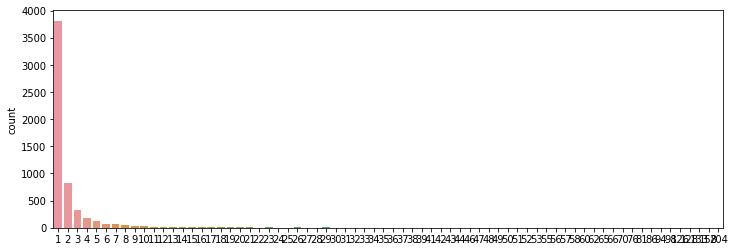

In [15]:
count = df_input["title"].value_counts()
plt.figure(figsize=(12,4))  
sns.countplot(list(count))
plt.show()

Most of the title are unique, or very rare appearance as shown by the high number in low counts. And the title information which includes make, model and engine cap are included in other columns alrdy, this column does give new information thus can possibly be droped.

- ### features, accessories, description

In [357]:
# features are almost unique
print(df_input.shape)
print(len(df_input["features"].unique()))

(16784, 135)
10688


In [358]:
def _remove_stopwords(tokens):
    stopwords_list = stopwords.words('english')
    tokens = [i for i in tokens if i not in stopwords_list]
    return tokens

def _remove_numbers(tokens):
    tokens = [i for i in tokens if not i.isdigit()]
    return tokens

def _to_lower_case(tokens):
    tokens = [word.lower() for word in tokens]
    return tokens

In [359]:
def add_basic_text_features(df):
    text_cols = ["features", "accessories", "description"]
    eng_stopwords = stopwords.words('english')
    
    for col in text_cols:
        df[f"{col}_num_words"] = df[col].apply(lambda x: len(str(x).split()))
        df[f"{col}_num_unique_words"] = df[col].apply(lambda x: len(set(str(x).split())))
        df[f"{col}_num_chars"] = df[col].apply(lambda x: len(str(x)))
        df[f"{col}_num_stopwords"] = df[col].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
        df[f"{col}_num_punctuations"] =df[col].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )        
        df[f"{col}_mean_word_len"] = df[col].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    return df

In [360]:
add_basic_text_features(df_input).head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,accessories_num_chars,accessories_num_stopwords,accessories_num_punctuations,accessories_mean_word_len,description_num_words,description_num_unique_words,description_num_chars,description_num_stopwords,description_num_punctuations,description_mean_word_len
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,2013-12-09,luxury sedan,"parf car, premium ad car, low mileage car",...,126,1,11,7.466667,47,44,304,8,13,5.489362
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,2015-01-26,van,premium ad car,...,91,0,4,7.363636,57,52,358,16,11,5.298246
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,2016-07-25,luxury sedan,"parf car, premium ad car",...,142,1,10,6.526316,39,36,228,11,10,4.871795
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,2020-11-17,luxury sedan,"parf car, almost new car, consignment car",...,148,0,9,6.842105,21,20,134,4,6,5.428571
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,2019-09-20,mid-sized sedan,parf car,...,150,1,10,6.947368,50,44,308,13,13,5.180000


### TF-IDF
- examine tfidf matrix for each row, find the tfidf that has the highest correlation with the target variable and add that as the feature

In [20]:
def generate_tfidf(column_name):
    dataset = list(df_input[column_name].dropna())
    tfIdfTransformer = TfidfTransformer(use_idf=True)
    countVectorizer = CountVectorizer()
    wordCount = countVectorizer.fit_transform(dataset)
    newTfIdf = tfIdfTransformer.fit_transform(wordCount)
    df_features_tfidf = pd.DataFrame(newTfIdf[0].T.todense(), 
                                     index=countVectorizer.get_feature_names(), 
                                     columns=["TF-IDF"])
    df_features_tfidf = df_features_tfidf.sort_values('TF-IDF', ascending=False)
    return df_features_tfidf

def build_wordcloud(tfidf_df):
    text = ''
    for word, tfidf in tfidf_df.to_dict()['TF-IDF'].items():
        for i in range(math.ceil(tfidf)):
            text = text + word + ' '

    wordcloud_features = WordCloud(stopwords=STOPWORDS, 
                                   background_color="white",
                                   width=10000, height=5000).generate(text)
    img_demo = plt.imshow(wordcloud_features)
    plt.axis("off")
    plt.show()

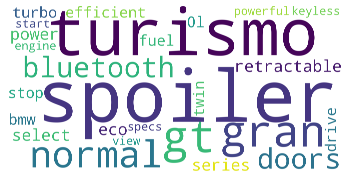

In [21]:
df_features_tfidf = generate_tfidf("features")
build_wordcloud(df_features_tfidf)

In [22]:
print(df_features_tfidf.shape)

(6381, 1)


In [23]:
df_features_tfidf.head()

,TF-IDF
spoiler,0.369231
turismo,0.348567
gt,0.283052
gran,0.271660
normal,0.263011


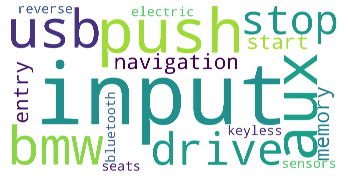

In [24]:
df_accessories_tfidf = generate_tfidf("accessories")
build_wordcloud(df_accessories_tfidf)

In [25]:
print(df_accessories_tfidf.shape)

(5185, 1)


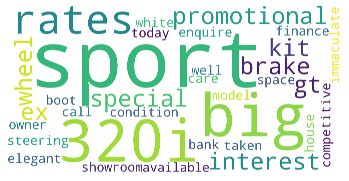

In [26]:
df_description_tfidf = generate_tfidf("description")
build_wordcloud(df_description_tfidf)

In [27]:
print(df_description_tfidf.shape)

(11095, 1)


In [28]:
def tfidf_vectorize(feature_name):
    corpus_train = list(df_input[feature_name].fillna(""))
#     corpus_test = list(df_input[feature_name].fillna(""))
    vectorizer = TfidfVectorizer()
    tfidf_train = vectorizer.fit_transform(corpus_train)
#     tfidf_test = vectorizer.transform(corpus_test)

    df_train = pd.DataFrame(tfidf_train.toarray())
    df_train.columns = vectorizer.get_feature_names()
#     df_test = pd.DataFrame(tfidf_test.toarray())
#     df_test.columns = vectorizer.get_feature_names()
    return vectorizer, df_train

def find_valid_corr(df_tfidf, df_input):
    df = df_tfidf.copy()
    features_valid_vars = [var for var in df.columns 
     if df[var].isnull().sum()/len(df) <0.8]

    df["price_target"] = df_input["price"]
    features_valid_vars = features_valid_vars + ["price_target"]
    return df[features_valid_vars].corr()   

def find_correlate_cols(df):
    df_corr = df.copy()
    df_corr.reset_index(inplace = True)
    valid_text_name_ls = [i for i in df_corr[np.abs(df_corr["price_target"]) > 0.1]["index"].to_list() 
                          if i != "price_target" and i not in stopwords.words('english')]
    return valid_text_name_ls

In [29]:
features_vectorizer, df_features_transformed = tfidf_vectorize("features")
accessories_vectorizer, df_accessories_transformed = tfidf_vectorize("accessories")
description_vectorizer, df_description_transformed = tfidf_vectorize("description")

df_features_transformed = df_features_transformed.replace({0: np.nan})
df_accessories_transformed = df_accessories_transformed.replace({0: np.nan})
df_description_transformed = df_description_transformed.replace({0: np.nan})

<AxesSubplot:>

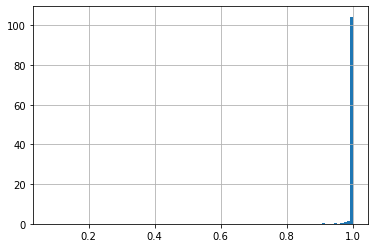

In [30]:
(df_features_transformed.isnull().sum()/len(df_features_transformed)).hist(bins=100, density=True)

<AxesSubplot:>

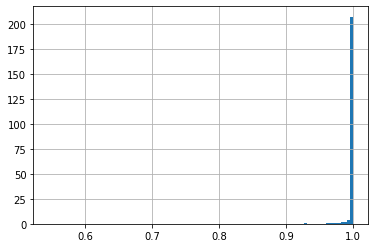

In [31]:
(df_accessories_transformed.isnull().sum()/len(df_accessories_transformed)).hist(bins=100, density=True)

<AxesSubplot:>

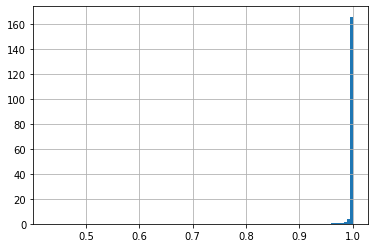

In [32]:
(df_description_transformed.isnull().sum()/len(df_description_transformed)).hist(bins=100, density=True)

In [33]:
df_features_corr = find_valid_corr(df_features_transformed, df_input)
features_col_ls = find_correlate_cols(df_features_corr)
df_features_tfidf= df_features_transformed[features_col_ls]
df_features_tfidf.columns = [f"{i}_features_tfidf" for i in df_features_tfidf.columns.to_list()]
df_features_tfidf.head()

,abs_features_tfidf,airbags_features_tfidf,auto_features_tfidf,dohc_features_tfidf,engine_features_tfidf,inline_features_tfidf,keyless_features_tfidf,specs_features_tfidf,start_features_tfidf,transmission_features_tfidf,view_features_tfidf
0,NaN,NaN,NaN,NaN,0.064967,NaN,0.108299,0.047846,0.112187,NaN,0.047834
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.067243,NaN,NaN,0.067226
2,0.131462,NaN,0.240826,NaN,0.085426,0.149807,NaN,0.062912,NaN,0.115229,0.062897
3,NaN,NaN,NaN,NaN,0.072906,0.127852,NaN,0.053692,NaN,NaN,0.053679
4,NaN,NaN,0.112648,NaN,0.079917,NaN,0.133219,0.058855,0.138002,0.107799,0.058841


In [34]:
df_accessories_corr = find_valid_corr(df_accessories_transformed, df_input)
accessories_col_ls = find_correlate_cols(df_accessories_corr)
df_accessories_tfidf= df_accessories_transformed[accessories_col_ls]
df_accessories_tfidf.columns = [f"{i}_accessories_tfidf" for i in df_accessories_tfidf.columns.to_list()]
df_accessories_tfidf.head()

,audio_accessories_tfidf,auto_accessories_tfidf,bluetooth_accessories_tfidf,camera_accessories_tfidf,leather_accessories_tfidf,reverse_accessories_tfidf,rims_accessories_tfidf,seats_accessories_tfidf,sensors_accessories_tfidf,sports_accessories_tfidf,steering_accessories_tfidf,system_accessories_tfidf
0,NaN,NaN,0.151463,NaN,NaN,0.111788,NaN,0.109490,0.14416,NaN,NaN,NaN
1,NaN,NaN,NaN,0.112507,NaN,0.102956,NaN,NaN,NaN,NaN,NaN,NaN
2,0.159275,NaN,0.161728,0.260871,NaN,0.119364,0.127328,0.116911,NaN,NaN,NaN,0.152217
3,NaN,NaN,0.117695,0.094922,NaN,0.086865,NaN,0.085080,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.113372,NaN,0.108096,0.099252,NaN,NaN,0.142965,0.129226


In [35]:
df_description_corr = find_valid_corr(df_description_transformed, df_input)
description_col_ls = find_correlate_cols(df_description_corr)
df_description_tfidf = df_description_transformed[description_col_ls]
df_description_tfidf.columns = [f"{i}_description_tfidf" for i in df_description_tfidf.columns.to_list()]
df_description_tfidf.head()

,low_description_tfidf
0,NaN
1,0.074884
2,0.109871
3,NaN
4,NaN


In [36]:
df_input = pd.concat([df_input, 
                      df_features_tfidf, 
                      df_accessories_tfidf, 
                    df_description_tfidf], axis = 1)

In [121]:
def test_tfidf_transform(df, vectorizer, feature_name, col_ls):
    text = list(df[feature_name].fillna(""))
    tfidf_test = vectorizer.transform(text)
    df_out = pd.DataFrame(tfidf_test.toarray())
    df_out.columns = vectorizer.get_feature_names()   
    return df_out[col_ls]

def add_tfidf(df):
    df_features_tfidf = test_tfidf_transform(df, features_vectorizer, "features", features_col_ls)
    df_features_tfidf.columns = [f"{i}_features_tfidf" for i in df_features_tfidf.columns.to_list()]
    df_accessories_tfidf = test_tfidf_transform(df, accessories_vectorizer, "accessories", accessories_col_ls)
    df_accessories_tfidf.columns = [f"{i}_accessories_tfidf" for i in df_accessories_tfidf.columns.to_list()]
    df_description_tfidf = test_tfidf_transform(df, description_vectorizer, "description", description_col_ls)
    df_description_tfidf.columns = [f"{i}_description_tfidf" for i in df_description_tfidf.columns.to_list()]
    
    df = pd.concat([df, df_features_tfidf, df_accessories_tfidf, df_description_tfidf], axis = 1)
    
    return df

### sentiment analysis

In [38]:
def add_sentiment_score(df):
    feature_ls = ["features", "accessories", "description"]
    df[feature_ls] = df[feature_ls].fillna("")
    for i in feature_ls:
        df[f"{i}_sentiment"] = df.apply(lambda x: TextBlob(x[i]).sentiment.polarity, axis=1)
    return df

In [39]:
add_sentiment_score(df_input).head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,rims_accessories_tfidf,seats_accessories_tfidf,sensors_accessories_tfidf,sports_accessories_tfidf,steering_accessories_tfidf,system_accessories_tfidf,low_description_tfidf,features_sentiment,accessories_sentiment,description_sentiment
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,NaN,0.109490,0.14416,NaN,NaN,NaN,NaN,0.225000,0.000000,0.229592
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,NaN,NaN,NaN,NaN,NaN,NaN,0.074884,0.000000,0.000000,0.401250
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,0.127328,0.116911,NaN,NaN,NaN,0.152217,0.109871,0.000000,0.000000,0.531250
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,NaN,0.085080,NaN,NaN,NaN,NaN,NaN,-0.066667,0.133333,0.500000
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,0.108096,0.099252,NaN,NaN,0.142965,0.129226,NaN,0.000000,0.000000,0.440625


/Users/user/.pyenv/versions/anaconda3-5.2.0/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


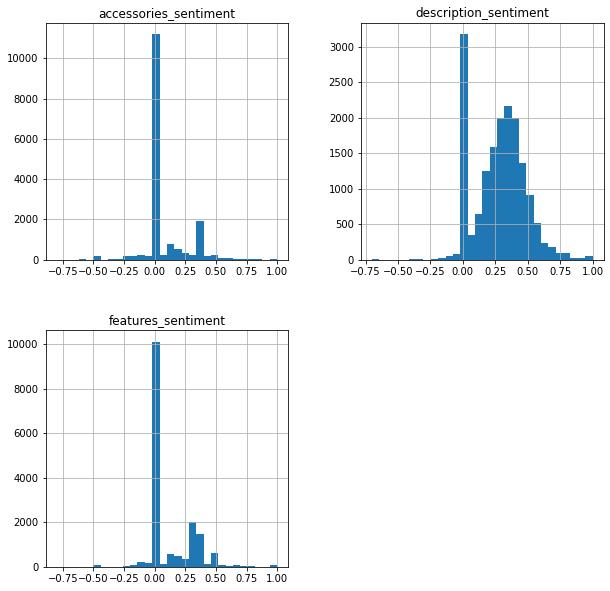

In [40]:
col_ls =["features", "accessories", "description"]
sentiment_conl = [f"{i}_sentiment" for i in col_ls]
df_input[sentiment_conl].hist(bins=30, figsize=(10,10))
plt.show()

In [41]:
sentiment_conl_target = sentiment_conl+["price"]
corr = df_input[sentiment_conl_target].corr()
corr

,features_sentiment,accessories_sentiment,description_sentiment,price
features_sentiment,1.000000,0.074818,0.000862,0.043828
accessories_sentiment,0.074818,1.000000,0.010610,0.078329
description_sentiment,0.000862,0.010610,1.000000,-0.018553
price,0.043828,0.078329,-0.018553,1.000000


Sentiment columns show very weak correlation with the target variables, not really useful features to be included

## Universal Sentence Encoder

In [42]:
import texthero as hero
from texthero import preprocessing
# !pip install --upgrade tensorflow_hub
import tensorflow_hub as hub
#download the model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [43]:
custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   # preprocessing.remove_punctuation
                  ]
df_input['features_clean'] = hero.clean(df_input['features'], custom_pipeline)

In [44]:
#generate embeddings
embeddings = embed(df_input['features_clean'])
#create list from np arrays
use= np.array(embeddings).tolist()
#add lists as dataframe column
df_input['features_use'] = use
df_input['tsneuse'] = hero.tsne(df_input['features_use'])
df_input["tsneuse_x"] = df_input["tsneuse"].apply(lambda x: x[0])
df_input["tsneuse_y"] = df_input["tsneuse"].apply(lambda x: x[1])
df_input["tsneuse_mean"] = df_input["tsneuse"].apply(lambda x: np.mean(x))
#check dataframe
df_input[['features', 'features_clean', 'features_use']].head(5)

,features,features_clean,features_use
0,"5 doors gt, powerful and fuel efficient 2.0l t...","5 doors gt, powerful and fuel efficient 2.0l t...","[-0.007007636595517397, -0.09033354371786118, ..."
1,low mileage unit. well maintained vehicle. vie...,low mileage unit. well maintained vehicle. vie...,"[0.08804768323898315, -0.102423757314682, 0.08..."
2,responsive and fuel efficient 1.6l inline 4 cy...,responsive and fuel efficient 1.6l inline 4 cy...,"[0.017077084630727768, -0.14287161827087402, 0..."
3,"1.5l inline-4 twin scroll turbocharged engine,...","1.5l inline-4 twin scroll turbocharged engine,...","[0.050994254648685455, -0.13971832394599915, -..."
4,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","[0.033324237912893295, -0.11933260411024094, -..."


In [45]:
df_input[["tsneuse_x", "tsneuse_y", "tsneuse_mean", "price"]].corr()

,tsneuse_x,tsneuse_y,tsneuse_mean,price
tsneuse_x,1.000000,0.005294,0.704954,0.006428
tsneuse_y,0.005294,1.000000,0.712975,0.232299
tsneuse_mean,0.704954,0.712975,1.000000,0.169269
price,0.006428,0.232299,0.169269,1.000000


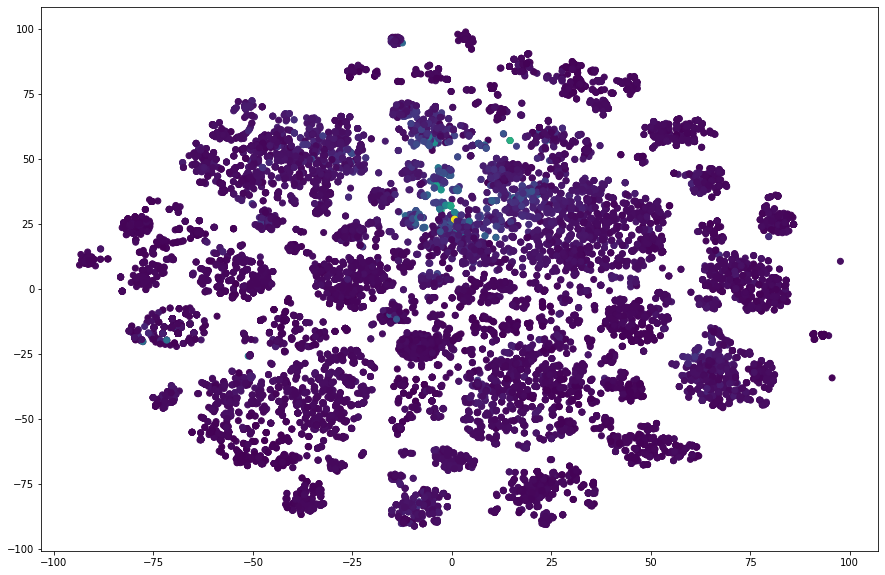

In [47]:
plt.figure(figsize=(15,10))
plt.scatter(df_input["tsneuse_x"], df_input["tsneuse_y"], c=df_input["price"])

In [73]:
def add_use_encode(df):
    for i in ["features", "accessories", "description"]:
        custom_pipeline = [preprocessing.fillna,
                           preprocessing.lowercase,
                           # preprocessing.remove_punctuation
                          ]
        df[f'{i}_clean'] = hero.clean(df[i], custom_pipeline)
        embeddings = embed(df[f'{i}_clean'])
        use= np.array(embeddings).tolist()
        df[f'{i}_use'] = use
        df[f'{i}_tsneuse'] = hero.tsne(df[f'{i}_use'])
        df[f'{i}_tsneuse_x'] = df[f'{i}_tsneuse'].apply(lambda x: x[0])
        df[f'{i}_tsneuse_y'] = df[f'{i}_tsneuse'].apply(lambda x: x[1])
        
    return df

In [49]:
# add_use_encode(df_input)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,accessories_clean,accessories_use,accessories_tsneuse,accessories_tsneuse_x,accessories_tsneuse_y,description_clean,description_use,description_tsneuse,description_tsneuse_x,description_tsneuse_y
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,"bmw i-drive, navigation, bluetooth/aux/usb inp...","[0.010138541460037231, -0.10628154873847961, 0...","[70.52999114990234, -32.43910598754883]",70.529991,-32.439106,1 owner! 320i gt m-sports model! big brake kit...,"[0.030527733266353607, -0.1529735028743744, 0....","[53.83613967895508, -24.248151779174805]",53.836140,-24.248152
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,factory radio setting. front recording camera....,"[-0.008469616062939167, -0.04779890924692154, ...","[-33.62293243408203, 41.15723419189453]",-33.622932,41.157234,high loan available! low mileage unit. wear an...,"[-0.012418252415955067, -0.14482544362545013, ...","[-7.446605682373047, -9.525193214416504]",-7.446606,-9.525193
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,dual electric/memory seats. factory fitted aud...,"[-0.028623105958104134, -0.05762699991464615, ...","[17.785444259643555, -76.37320709228516]",17.785444,-76.373207,1 owner c&c unit. full agent service with 1 mo...,"[0.05681028589606285, -0.12092626094818115, 0....","[-22.13946533203125, 8.750589370727539]",-22.139465,8.750589
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,64 colour ambient lighting. active parking ass...,"[0.0308124590665102, 0.02001580409705639, -0.0...","[16.46129608154297, -67.98200225830078]",16.461296,-67.982002,"fully agent maintained, 3 years warranty 10 ye...","[-0.012602495029568672, -0.07061905413866043, ...","[-14.168417930603027, 18.945188522338867]",-14.168418,18.945189
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,"s/rims, premium leather seats, factory touch s...","[0.0019430328393355012, -0.10368283838033676, ...","[-65.3883056640625, -28.947277069091797]",-65.388306,-28.947277,"kah motor unit! 1 owner, lowest 1.98% for full...","[0.035964470356702805, -0.14148706197738647, 0...","[-35.50501251220703, 10.788422584533691]",-35.505013,10.788423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16779,1030181,Volvo XC90 T5 Momentum,volvo,xc90,"just arrived, serviced and maintained by wearn...",2015.0,NaN,22-jan-2016,suv,"parf car, premium ad car",...,"city safety with pedestrian/cyclist detection,...","[0.03016054444015026, -0.015637148171663284, 0...","[24.022380828857422, -65.8087387084961]",24.022381,-65.808739,"just arrived, serviced and maintained by wearn...","[-0.002064789179712534, -0.088286854326725, 0....","[16.319538116455078, -26.935142517089844]",16.319538,-26.935143
16780,1027041,Hyundai Ioniq Hybrid 1.6A DCT Sunroof,hyundai,ioniq,one owner unit! 10 years hybrid battery till 0...,2017.0,NaN,11-may-2017,hatchback,"parf car, premium ad car, hybrid cars",...,"17"" rims, leather upholstery, reverse camera/s...","[-0.06676888465881348, -0.034422628581523895, ...","[19.066810607910156, -0.29844531416893005]",19.066811,-0.298445,one owner unit! 10 years hybrid battery till 0...,"[-0.028422363102436066, -0.11361413449048996, ...","[1.0857136249542236, 3.296654224395752]",1.085714,3.296654
16781,1021099,MINI Cooper Cabriolet 1.6A (COE till 08/2030),mini,coope

## simple text feature extraction
- is_loan
- is_warranty

In [339]:
df_input["is_warranty_features"] = np.where(df_input["features"].str.contains('warranty'), 1, 0) 
df_input["is_warranty_description"] = np.where(df_input["description"].str.contains('warranty'), 1, 0) 
df_input["is_warranty_accessories"] = np.where(df_input["accessories"].str.contains('warranty'), 1, 0) 

df_input["is_loan_features"] = np.where(df_input["features"].str.contains('loan'), 1, 0) 
df_input["is_loan_description"] = np.where(df_input["description"].str.contains('loan'), 1, 0) 
df_input["is_loan_accessories"] = np.where(df_input["accessories"].str.contains('loan'), 1, 0) 

df_input["is_warranty"] = np.where((df_input["is_warranty_features"] == 1) |  
                                    (df_input["is_warranty_description"] == 1) |
                                    (df_input["is_warranty_accessories"] == 1), 1, 0)
df_input["is_loan"] = np.where((df_input["is_loan_features"]  == 1)| 
                                (df_input["is_loan_description"] == 1) |
                                (df_input["is_loan_accessories"] == 1), 1, 0)

In [340]:
df_input[['is_warranty_description', 'is_warranty_features',
         'is_warranty_accessories', 'is_loan_features', 'is_loan_description', 'is_loan_accessories',
         'is_warranty', 'is_loan']].sum()

is_warranty_description     4872
is_warranty_features         597
is_warranty_accessories     2898
is_loan_features             493
is_loan_description         9439
is_loan_accessories         2867
is_warranty                 7053
is_loan                    10841
dtype: int64

In [341]:
def add_loan_warranty_features(df):
    for i in ['warranty', 'loan']:
        df[f"is_{i}_features"] = np.where(df["features"].str.contains(i), 1, 0) 
        df[f"is_{i}_description"] = np.where(df["description"].str.contains(i), 1, 0) 
        df[f"is_{i}_accessories"] = np.where(df["accessories"].str.contains(i), 1, 0) 

        df[f"is_{i}"] = np.where((df[f"is_{i}_features"] == 1) |  
                                (df[f"is_{i}_description"] == 1) |
                                (df[f"is_{i}_accessories"] == 1), 1, 0)
    return df

In [342]:
df_input = add_loan_warranty_features(df_input)

# Categorical features
- low dimensionality to use one hot encoding (fuel_type, type_of_vehicle)
- higher deimensionality to use target encoding

In [11]:
df_input[cat_vars].head(5)

,title,make,model,description,type_of_vehicle,category,transmission,fuel_type,opc_scheme,eco_category,features,accessories,listing_id
0,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,luxury sedan,"parf car, premium ad car, low mileage car",auto,NaN,NaN,uncategorized,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",1030324
1,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,van,premium ad car,manual,diesel,NaN,uncategorized,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,1021510
2,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,luxury sedan,"parf car, premium ad car",auto,NaN,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,1026909
3,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",luxury sedan,"parf car, almost new car, consignment car",auto,NaN,NaN,uncategorized,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,1019371
4,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",mid-sized sedan,parf car,auto,NaN,NaN,uncategorized,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",1031014


In [12]:
df_input[cat_vars].nunique().sort_values(ascending=False)

listing_id         16728
description        14006
accessories        11565
features           10687
title               5775
model                692
category             193
make                  77
type_of_vehicle       11
fuel_type              4
opc_scheme             3
transmission           2
eco_category           1
dtype: int64

In [13]:
def add_one_hot_encode(df):
    col_ls = ["transmission", "fuel_type", "type_of_vehicle"]
    
    for col in col_ls:
        unique_vals = list(df[col].unique())
        for val in unique_vals:
            df[f"is_{val}"] = np.where(df[col] == val, 1, 0)
    
    return df

In [14]:
add_one_hot_encode(df_input).head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,is_van,is_mid-sized sedan,is_sports car,is_hatchback,is_suv,is_truck,is_mpv,is_stationwagon,is_bus/mini bus,is_others
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,0,0,0,0,0,0,0,0,0,0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,1,0,0,0,0,0,0,0,0,0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,0,0,0,0,0,0,0,0,0,0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,0,0,0,0,0,0,0,0,0,0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,0,1,0,0,0,0,0,0,0,0


In [15]:
def add_make_model(df):
    df['make_fill'] = df.apply(lambda x: x["make"] if not pd.isnull(x["make"]) else x["title"].lower().split()[0], axis = 1)
    df["make_model"] = df["make_fill"] + " " + df["model"]
    return df

In [16]:
add_make_model(df_input).head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,is_sports car,is_hatchback,is_suv,is_truck,is_mpv,is_stationwagon,is_bus/mini bus,is_others,make_fill,make_model
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,0,0,0,0,0,0,0,0,bmw,bmw 320i
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,0,0,0,0,0,0,0,0,toyota,toyota hiace
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,0,0,0,0,0,0,0,0,mercedes-benz,mercedes-benz cla180
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,0,0,0,0,0,0,0,0,mercedes-benz,mercedes-benz e180
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,0,0,0,0,0,0,0,0,honda,honda civic


In [17]:
cat_encode_vars = [
 'make_fill',
 'model',
 "make_model",
 'type_of_vehicle',
 'transmission',
 'fuel_type']

In [18]:
df_input[cat_encode_vars].isnull().sum()/len(df_input)

make_fill          0.000000
model              0.000000
make_model         0.000000
type_of_vehicle    0.000000
transmission       0.000000
fuel_type          0.792064
dtype: float64

In [20]:
JSE_encoder = JamesSteinEncoder()
train_jse = JSE_encoder.fit_transform(df_input[cat_encode_vars], df_input["price"])
train_jse.columns = [f"{i}_jse_encode" for i in train_jse.columns]

LOOE_encoder = LeaveOneOutEncoder()
train_looe = LOOE_encoder.fit_transform(df_input[cat_encode_vars], df_input["price"])
train_looe.columns = [f"{i}_looe_encode" for i in train_looe.columns]

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(df_input[cat_encode_vars], df_input["price"])
train_cbe.columns = [f"{i}_cbe_encode" for i in train_cbe.columns]

In [21]:
df_input = pd.concat([df_input, train_jse, train_looe, train_cbe], axis=1)
df_input.head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,make_model_looe_encode,type_of_vehicle_looe_encode,transmission_looe_encode,fuel_type_looe_encode,make_fill_cbe_encode,model_cbe_encode,make_model_cbe_encode,type_of_vehicle_cbe_encode,transmission_cbe_encode,fuel_type_cbe_encode
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,97117.241379,137579.136691,117628.075397,117732.212443,112910.164442,112910.164442,112910.164442,112910.164442,112910.164442,112910.164442
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,67085.422741,54709.581395,70055.716005,74012.314327,112910.164442,112910.164442,112910.164442,112910.164442,112910.164442,112910.164442
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,98335.833333,137571.223022,117626.474868,117730.391936,112910.164442,112910.164442,112910.164442,92105.082221,92105.082221,92105.082221
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,201800.000000,137537.737083,117619.702381,117722.688633,104205.082221,112910.164442,112910.164442,93236.721481,93236.721481,93236.721481
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,74417.678100,54831.712875,117625.965608,117729.812683,112910.164442,112910.164442,112910.164442,112910.164442,119402.541111,119402.541111


In [353]:
df_make_model_count = pd.DataFrame(df_input['make_model'].value_counts()).reset_index()
df_make_model_count = df_make_model_count.rename(columns={"index": "make_model",
                           "make_model": "make_model_count"})
df_make_model_count.to_csv("/Users/user/Desktop/cs5228_project_MARS/data/processed/make_model_count.csv")

In [354]:
def add_count_features(df, df_lookup):
    df_merge = pd.merge(df, df_lookup, on='make_model', how = 'left')
    return df_merge

In [355]:
df_input = add_count_features(df_input, df_make_model_count)

# Time variable
- drop original_reg_date

In [312]:
df_input[time_vars].isnull().mean().sort_values(ascending=False)

original_reg_date    0.981053
lifespan             0.898594
reg_date             0.011976
manufactured         0.011618
dtype: float64

In [310]:
def _convert_epoch_time(df, col_name):
     output = (pd.to_datetime(df[col_name], utc=True) - pd.Timestamp("1970-01-01", tz='UTC')) // pd.Timedelta('1s')

# Add binning for manufactured: https://americancollectors.com/articles/vintage-vs-classic-vs-antique-cars/
def add_time_features(df):
    df["is_lifespan_missing"] = np.where(df["lifespan"].isna(), 1, 0)
    
    df["lifespan"] = pd.to_datetime(df["lifespan"])
    df["reg_date"] = pd.to_datetime(df["reg_date"])
    df["lifespan_year"] = df["lifespan"].dt.year
    df["lifespan_month"] = df["lifespan"].dt.month
    df["reg_date_year"] = df["reg_date"].dt.year
    df["reg_date_month"] = df["reg_date"].dt.month
    
    df["manufactured"] = df.apply(lambda x: np.NaN if x["reg_date_year"] < x["manufactured"] else x["manufactured"], axis=1)
    df["manufactured_to_reg_year"] = df["reg_date_year"] - df["manufactured"]
    df["lifespan_to_reg_year"] = df["lifespan_year"] - df["reg_date_year"]
    df["car_age"] = df.apply(lambda x: np.ceil(((2021-x['reg_date_year']) * 12 + 10-x['reg_date_month'])/12), axis = 1)
    df["car_age_manufactured"] = df.apply(lambda x: 2021-x['manufactured'], axis = 1)
    
    df["is_vintage_car"] = np.where((df["manufactured"] >= 1919)&(df["manufactured"] <= 1930), 1, 0)
    df["is_antique_car"] = np.where((df["manufactured"] >1930)&(df["manufactured"] <= 1975) & 
                                    (df["car_age_manufactured"]) > 45, 1, 0)
    df["is_classic_car"] = np.where((df["manufactured"] >1975)&(df["manufactured"] <= 1990)& 
                                    (df["car_age_manufactured"]) > 20, 1, 0)
    
    return df

In [313]:
add_time_features(df_input).head()

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,car_age_manufactured,depreciation_calculated,depreciation_fill,road_tax_calculated,road_tax_fill,mileage_mean,mileage_fill,is_vintage_car,is_antique_car,is_classic_car
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,2013-12-09,luxury sedan,"parf car, premium ad car, low mileage car",...,8.0,0.0,17700.0,1208.5810,1210.000,97981.991643,73000.0,0,0,0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,2015-01-26,van,premium ad car,...,7.0,0.0,11630.0,2363.9860,2363.986,88568.489117,110112.0,0,0,0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,2016-07-25,luxury sedan,"parf car, premium ad car",...,5.0,0.0,15070.0,739.9675,740.000,78528.242268,80000.0,0,0,0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,2020-11-17,luxury sedan,"parf car, almost new car, consignment car",...,2.0,NaN,16400.0,682.4905,684.000,4323.891142,9800.0,0,0,0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,2019-09-20,mid-sized sedan,parf car,...,2.0,0.0,10450.0,741.1405,742.000,33515.951136,40000.0,0,0,0


# Numerical features
- drop indicative_price
- backfill missing data for others

In [8]:
df_input[num_vars].isnull().sum()/len(df_input)

curb_weight         0.034497
power               0.139240
engine_cap          0.003158
no_of_owners        0.010486
depreciation        0.025798
coe                 0.053086
road_tax            0.128337
dereg_value         0.070841
mileage             0.221878
omv                 0.002443
arf                 0.016921
indicative_price    1.000000
dtype: float64

In [47]:
df_input[df_input["no_of_owners"].isnull()]['manufactured'].unique()

array([  nan, 2020., 2019., 2017., 1992., 2021., 2011., 2007.])

In [44]:
def look_up_missing(df_origin, var_name, df_lookup, merge_col):
    selected_col = merge_col + [f"{var_name}_mean"]
    df_origin = pd.merge(df_origin, df_lookup[selected_col], how='left', on=merge_col)
    df_origin[f"{var_name}_missing"] = np.where(df_origin[var_name].isnull(), 1, 0)
    df_origin[f"{var_name}_fill"] = np.where(df_origin[var_name].isnull(),
                                           df_origin[f"{var_name}_mean"],
                                           df_origin[var_name])
    return df_origin

## omv - arf
- ARF: based on OMV of the vehicale and ranges from 100% to 180% of your car's value (https://www.sgcarmart.com/new_cars/popups/whatsARF.php)
- PARF: when the car is de-registered and scraped at the end of the 10 year period, a preferential additional registration fee (PARF) can be received from LTA (amount based on ARF)
- Annual Depreciation = (Total Cost of Vehicle – Sale Value of Vehicle) / Number of Years in Service where Total Cost of Vehicle = OMV+COE+RF+ARF and Sale Value = sale_price + PARF

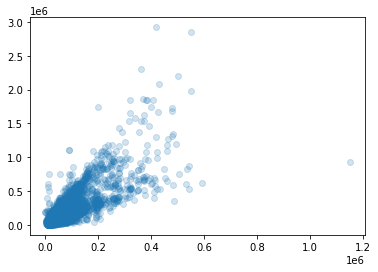

In [94]:
plt.scatter(df_input['omv'], df_input['price'], alpha = 0.2)

In [97]:
df_input[df_input['omv'] > 1000000]

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,power_missing,power_fill,curb_weight_mean,curb_weight_missing,curb_weight_fill,engine_cap_mean,engine_cap_missing,engine_cap_fill,arf_fill,arf_diff
5361,1028924,Toyota Century 5.0A,toyota,century,"new, rare century, only one in the market. vis...",NaN,21-aug-2021,NaN,luxury sedan,"imported used vehicle, coe car, rare & exotic",...,1,NaN,NaN,1,NaN,NaN,0,4960.0,2042000.0,NaN


In [127]:
# VES rebate should be subtracted but now sure how? (https://www.sgcarmart.com/news/article.php?AID=7193)
def calculate_arf(omv):
    if omv <= 20000:
        arf = omv
    elif omv <= 50000:
        arf = 20000 + (omv-20000)*1.4
    elif omv >50000:
        arf = 20000 + 30000*1.4 + (omv-50000)*1.8
    elif pd.isnull(omv):
        arf = np.NaN
    return arf


In [150]:
# bin omv to distinguish the grouping in the same make_model
df_input['omv_bin'] = df_input['omv'].apply(lambda x: np.floor(x/10000))

df_arf_lookup = df_input.groupby(['make_model', 'reg_date_year','omv_bin']).agg({'arf': ['mean']}).reset_index()
df_arf_lookup.columns = ['_'.join(col).strip() for col in df_arf_lookup.columns.values]
df_arf_lookup = df_arf_lookup.rename(columns={'make_model_': 'make_model', 
                                              'reg_date_year_':'reg_date_year', 
                                              'omv_bin_':'omv_bin',
                                             'arf_mean': 'arf_lookup'})

In [156]:
# df_input = pd.merge(df_input, df_arf_lookup, on=['make_model', 'reg_date_year','omv_bin'], 
#                    how='left')

df_input["arf_calculated"] = df_input["omv"].apply(lambda x: calculate_arf(x))
# df_input['arf_fill'] = np.where(df_input['arf'].isnull(), df_input['arf_lookup'], df_input['arf'])
df_input['arf_fill'] = np.where(df_input['arf'].isnull(), df_input['arf_calculated'], df_input['arf_fill'])

In [390]:
def backfill_arf(df):
    df["arf_calculated"] = df["omv"].apply(lambda x: calculate_arf(x))
    df['arf_fill'] = np.where(df['arf'].isnull(), df['arf_calculated'], df['arf'])
    
    return df

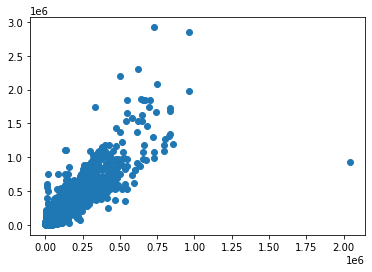

In [158]:
plt.scatter(df_input['arf_fill'], df_input['price'])

In [157]:
df_input[['arf','arf_fill', 'arf_lookup','arf_calculated', 'omv', 'price']].corr()

,arf,arf_fill,arf_lookup,arf_calculated,omv,price
arf,1.000000,1.000000,0.998834,0.938259,0.938438,0.884832
arf_fill,1.000000,1.000000,0.998834,0.944932,0.944218,0.868794
arf_lookup,0.998834,0.998834,1.000000,0.938716,0.938759,0.884675
arf_calculated,0.938259,0.944932,0.938716,1.000000,0.998212,0.801796
omv,0.938438,0.944218,0.938759,0.998212,1.000000,0.804580
price,0.884832,0.868794,0.884675,0.801796,0.804580,1.000000


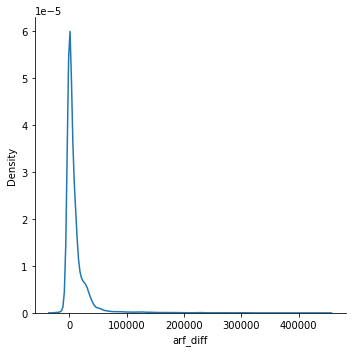

In [70]:
df_input['arf_diff'] = df_input['arf_fill'] - df_input['arf']
sns.displot(df_input, x="arf_diff", kind="kde")

In [123]:
df_input['arf_diff'].describe()

count     16500.000000
mean      10713.866873
std       26213.495119
min      -24647.200000
25%           0.000000
50%        1824.800000
75%       10000.000000
max      445704.800000
Name: arf_diff, dtype: float64

In [159]:
print (f'arf original missing: {df_input["arf"].isnull().sum()/len(df_input)}')
print (f'arf original missing: {df_input["arf_fill"].isnull().sum()/len(df_input)}')

arf original missing: 0.016920877025738797
arf original missing: 0.0024428026692087704


## coe
- There are 2 rounds happening each month of the year with each one have a different quota and COE premium.

In [401]:
df_coe_lookup = df_input.groupby(['reg_date_year', 'reg_date_month']).agg({'coe':'mean'}).reset_index()
df_coe_lookup = df_coe_lookup.rename(columns={'coe': 'coe_mean'})
#df_coe_lookup.to_csv("/Users/user/Desktop/cs5228_project_MARS/data/processed/coe_lookup.csv")

In [195]:
df_input = look_up_missing(df_input, 'coe', df_coe_lookup, ['reg_date_year', 'reg_date_month'])

In [411]:
def backfill_coe(df, coe_lookup_path):
    df_coe_lookup = pd.read_csv(coe_lookup_path)
    df = look_up_missing(df, 'coe', df_coe_lookup, ['reg_date_year', 'reg_date_month'])
    
    return df

In [198]:
print (f'coe original missing: {df_input["coe"].isnull().sum()/len(df_input)}')
print (f'coe original missing: {df_input["coe_fill"].isnull().sum()/len(df_input)}')

arf original missing: 0.053086272640610103
arf original missing: 0.0005362249761677788


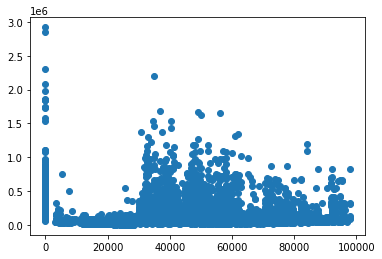

In [196]:
plt.scatter(df_input['coe_fill'], df_input['price'])

In [197]:
df_input[['coe_fill', 'coe', 'price']].corr()

,coe_fill,coe,price
coe_fill,1.000000,1.000000,0.054555
coe,1.000000,1.000000,0.047125
price,0.054555,0.047125,1.000000


## dereg_value
- reference: https://www.sgcarmart.com/news/writeup.php?AID=13

In [200]:
df_input[df_input['is_coe_car'] == 1][['title', 'is_coe_car']]

,title,is_coe_car
5,Mercedes-Benz A-Class A35 AMG 4MATIC Premium Plus,1
8,Toyota Corolla Altis 1.6A (COE till 04/2031),1
11,Honda City 1.5A LX i-VTEC (COE till 02/2029),1
15,Toyota Estima 2.4A Aeras (COE till 06/2028),1
18,Ferrari 575M Maranello (COE till 08/2024),1
...,...,...
16768,Man 14.280 HOCL-R (COE till 04/2025),1
16769,Mitsubishi Lancer 1.6M GLX (COE till 11/2029),1
16771,Mercedes-Benz C-Class C180K (New 10-yr COE),1
16774,Audi S5 Coupe 4.2A FSI Quattro (COE till 09/2029),1


In [240]:
def find_coe_date(title, is_coe_car):
    if is_coe_car == 1 and 'COE' in title:
        try:
            coe_date = title.split('(')[1].split(')')[0].split(' ')[2]
            return datetime.datetime.strptime(coe_date, "%m/%Y")
        except:
            return np.NaN
    return np.NaN

def add_coe_date_features(df):
    df['coe_date'] = df.apply(lambda x: find_coe_date(x['title'], x['is_coe_car']), axis = 1)
    df['coe_date_year'] = df['coe_date'].dt.year
    df['coe_date_month'] = df['coe_date'].dt.month 
    df['coe_month_left'] = df.apply(lambda x: (x['coe_date_year']-2021)*12 + x['coe_date_month']-10, axis=1)
    return df

In [241]:
df_input = add_coe_date_features(df_input)

In [251]:
def calculate_dereg_value(arf, car_age, coe_month_left, coe, is_coe_car):
    try:
        if is_coe_car == 1 and not pd.isnull(coe_date):
            # taking as of this 2021-10
            # unused coe duration * coe
            coe_val = coe_month_left/120
        else:
            coe_val = 0

        if car_age <= 5:
            parf = 0.75 * arf
        elif car_age <= 6:
            parf = 0.7 * arf
        elif car_age <= 7:
            parf = 0.65 * arf
        elif car_age <= 8:
            parf = 0.6 * arf
        elif car_age <= 9:
            parf = 0.55 * arf
        elif car_age <= 10:
            parf = 0.5 * arf
        else:
            parf = 0
    
        return coe_val+parf
    except:
        return np.NaN

In [392]:
def backfill_dereg_value(df):
    df["dereg_value_calculated"] = df.apply(lambda x: calculate_dereg_value(x['arf_fill'],
                                                                    x['car_age'],
                                                                    x['coe_month_left'], 
                                                                    x['coe_fill'], 
                                                                    x['is_coe_car']), axis = 1)
    df['dereg_value_fill'] = np.where(df['dereg_value'].isnull(), df['dereg_value_calculated'], df['dereg_value'])
    
    return df

In [252]:
df_input["dereg_value_calculated"] = df_input.apply(lambda x: calculate_dereg_value(x['arf_fill'], 
                                                                             x['car_age'], 
                                                                             x['coe_month_left'], 
                                                                             x['coe_fill'], 
                                                                             x['is_coe_car'])
                                             ,axis = 1)

df_input['dereg_value_fill'] = np.where(df_input['dereg_value'].isnull(), df_input['dereg_value_calculated'], 
                                        df_input['dereg_value'])

In [253]:
print (f'dereg_value original missing: {df_input["dereg_value"].isnull().sum()/len(df_input)}')
print (f'dereg_value original missing: {df_input["dereg_value_fill"].isnull().sum()/len(df_input)}')

dereg_value original missing: 0.07084127740705434
dereg_value original missing: 0.06530028598665395


In [246]:
df_input[['dereg_value_fill', 'coe_month_left', 'dereg_value', 'price']].corr()

,dereg_value_fill,coe_month_left,dereg_value,price
dereg_value_fill,1.000000,0.909697,1.000000,0.890101
coe_month_left,0.909697,1.000000,0.909697,0.496467
dereg_value,1.000000,0.909697,1.000000,0.894838
price,0.890101,0.496467,0.894838,1.000000


## depreciation

In [255]:
rf = 140
def calculate_depreciation(omv, arf, coe, dereg_value, car_age):
    try: 
        rf = 140
        return (omv+arf+coe+rf - dereg_value)/car_age
    except:
        return np.NaN

In [394]:
def backfill_depreciation(df):
    df["depreciation_calculated"] = df.apply(lambda x: calculate_depreciation(x['omv'], 
                                                                             x['arf_fill'], 
                                                                             x['coe_fill'], 
                                                                             x['dereg_value_fill'], 
                                                                             x['car_age']), axis = 1)
    df['depreciation_fill'] = np.where(df['depreciation'].isnull(), df['depreciation_calculated'], df['depreciation'])
    
    return df

In [256]:
df_input["depreciation_calculated"] = df_input.apply(lambda x: calculate_dereg_value(x['omv'], 
                                                                             x['arf_fill'], 
                                                                             x['coe_fill'], 
                                                                             x['dereg_value_fill'], 
                                                                             x['car_age'])
                                             ,axis = 1)

df_input['depreciation_fill'] = np.where(df_input['depreciation'].isnull(), df_input['depreciation_calculated'], 
                                        df_input['depreciation'])

In [258]:
df_input[['depreciation_fill', 'depreciation', 'price']].corr()

,depreciation_fill,depreciation,price
depreciation_fill,1.0000,1.000000,0.501600
depreciation,1.0000,1.000000,0.631857
price,0.5016,0.631857,1.000000


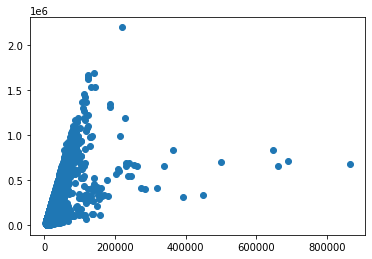

In [262]:
plt.scatter(df_input['depreciation'], df_input['price'])

## road_tax
- reference: https://www.sgcarmart.com/services/roadtax_calculator.php

In [284]:
def calculate_road_tax(engine_cap, car_age):
    try:
        if engine_cap <= 600:
            tax = 400 * 0.782
        elif engine_cap <= 1000:
            tax = (400 + 0.25*(engine_cap - 600))*0.782
        elif engine_cap <= 1600:
            tax = (500 + 0.75*(engine_cap - 1000))*0.782
        elif engine_cap <=3000:
            tax = (950 + 1.5*(engine_cap - 1600))*0.782
        elif engine_cap > 3000: 
            tax = (3050 + 2*(engine_cap - 3000))*0.782
        
        if car_age <= 10 or pd.isnull(car_age):
            multiplier = 1
        elif car_age <= 11:
            multiplier = 1.1
        elif car_age <= 12:
            multiplier = 1.2
        elif car_age <= 13:
            multiplier = 1.3
        elif car_age <= 14:
            multiplier = 1.4
        else:
            multiplier = 1.5
        return tax * multiplier
    except:
        return np.NaN
        

In [395]:
def backfill_road_tax(df):
    df["road_tax_calculated"] = df.apply(lambda x: calculate_road_tax(x['engine_cap'], x['car_age']), axis = 1)
    df['road_tax_fill'] = np.where(df['road_tax'].isnull(), df['road_tax_calculated'], df['road_tax'])
    
    return df

In [285]:
df_input["road_tax_calculated"] = df_input.apply(lambda x: calculate_road_tax(x['engine_cap'], x['car_age'])
                                             ,axis = 1)

df_input['road_tax_fill'] = np.where(df_input['road_tax'].isnull(), df_input['road_tax_calculated'], 
                                        df_input['road_tax'])

In [288]:
df_input[df_input['car_age']>10][['engine_cap', 'car_age','road_tax_fill','road_tax_calculated', 'road_tax', 'price']]

,engine_cap,car_age,road_tax_fill,road_tax_calculated,road_tax,price
8,1598.0,11.0,816.0000,815.89970,816.0,66900.0
11,1497.0,13.0,889.0000,887.23765,889.0,52600.0
15,2362.0,14.0,2293.0000,2291.41640,2293.0,57000.0
18,5748.0,18.0,10026.0000,10024.45800,10026.0,462000.0
20,1984.0,12.0,1433.0000,1431.99840,1433.0,79000.0
...,...,...,...,...,...,...
16766,1586.0,12.0,883.0000,881.62680,883.0,24100.0
16768,6871.0,12.0,10127.2128,10127.21280,NaN,49500.0
16769,1584.0,12.0,881.0000,880.21920,881.0,61600.0
16774,4163.0,13.0,5047.0000,5465.24160,5047.0,96800.0


In [289]:
df_input[['road_tax_fill', 'road_tax', 'price']].corr()

,road_tax_fill,road_tax,price
road_tax_fill,1.000000,1.000000,0.350104
road_tax,1.000000,1.000000,0.610232
price,0.350104,0.610232,1.000000


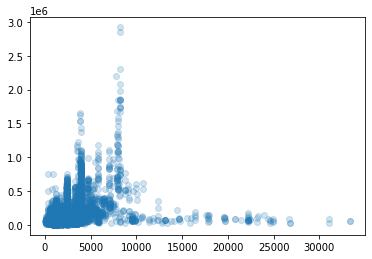

In [290]:
plt.scatter(df_input['road_tax_fill'], df_input['price'], alpha = 0.2)

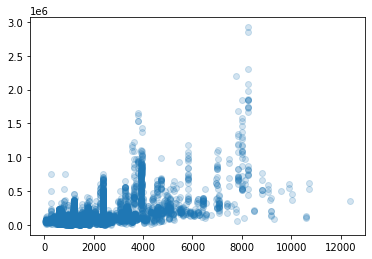

In [274]:
plt.scatter(df_input['road_tax'], df_input['price'], alpha = 0.2)

## curb_weight, power, engine_cap

In [22]:
num_vars_with_target = num_vars + [target]
df_input[num_vars_with_target].corr()

,curb_weight,power,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,indicative_price,price
curb_weight,1.000000,0.669867,0.799242,-0.007923,0.110635,0.049650,0.640940,0.103412,0.002556,0.274464,0.115930,NaN,0.138473
power,0.669867,1.000000,0.884905,0.144118,0.591131,0.251833,0.842316,0.699425,-0.139015,0.849986,0.843883,NaN,0.769550
engine_cap,0.799242,0.884905,1.000000,0.126226,0.347337,0.048805,0.966132,0.303947,-0.004413,0.619083,0.478709,NaN,0.418161
no_of_owners,-0.007923,0.144118,0.126226,1.000000,0.020780,-0.163647,0.284439,-0.206982,0.532323,0.127511,0.104119,NaN,-0.092642
depreciation,0.110635,0.591131,0.347337,0.020780,1.000000,0.281593,0.489024,0.555946,-0.158536,0.678950,0.656705,NaN,0.631857
coe,0.049650,0.251833,0.048805,-0.163647,0.281593,1.000000,0.110904,0.331103,-0.005319,0.160858,0.234678,NaN,0.047125
road_tax,0.640940,0.842316,0.966132,0.284439,0.489024,0.110904,1.000000,0.459083,0.018472,0.816899,0.769150,NaN,0.610232
dereg_value,0.103412,0.699425,0.303947,-0.206982,0.555946,0.331103,0.459083,1.000000,-0.376528,0.712710,0.849308,NaN,0.894838
mileage,0.002556,-0.139015,-0.004413,0.532323,-0.158536,-0.005319,0.018472,-0.376528,1.000000,-0.149942,-0.170006,NaN,-0.387148
omv,0.274464,0.849986,0.619083,0.127511,0.678950,0.160858,0.816899,0.712710,-0.149942,1.000000,0.938438,NaN,0.804580


In [27]:
df_power_null = df_input[df_input["power"].isnull()]
df_power_filter = df_input[df_input["make_model"].isin(df_power_null["make_model"])][['title','power', 'description', 'make_model']]
df_power_filter["power_is_null"] = df_power_filter["power"].isnull()
df_power_filter["helper"] = 1
df_power_filter["power_is_null"] = df_power_filter.groupby('make_model')["power_is_null"].transform('sum').astype(int)
df_power_filter["total_case"] = df_power_filter.groupby('make_model')["helper"].transform('sum').astype(int)
df_power_filter["%null"] = df_power_filter["power_is_null"]/df_power_filter["total_case"]
df_power_filter.groupby('make_model').agg({'%null': 'first'})

,%null
make_model,
alfa romeo a156,1.000000
alfa romeo spider,1.000000
alfa romeo stelvio,1.000000
audi a5,0.011494
audi a7,0.066667
...,...
volkswagen kombi,0.400000
volkswagen transporter,1.000000
volvo v70,0.500000


/Users/user/.pyenv/versions/anaconda3-5.2.0/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


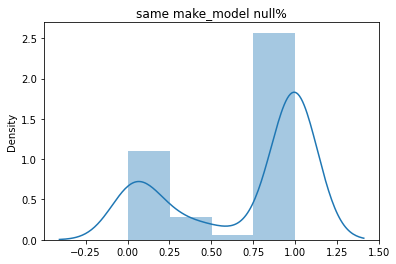

In [28]:
sns.distplot(df_power_filter.groupby('make_model').agg({'%null': 'first'}) )
plt.title('same make_model null%')
plt.show()

In [29]:
# use the average of make_model to backfill power
make_model_features = ["curb_weight", "power", "engine_cap"]

agg_dic = {}
for i in make_model_features:
    agg_dic[i] = "mean"
    
df_num_vars_lookup = df_input.groupby(["transmission", "make_model", "manufactured"]).agg(agg_dic).reset_index()
df_num_vars_lookup.columns = ['transmission', 'make_model', 'manufactured', 'curb_weight_mean', 'power_mean', 'engine_cap_mean']
#df_num_vars_lookup.to_csv("/Users/user/Desktop/cs5228_project_MARS/data/processed/make_model_features_average_lookup_no_fuel.csv")

In [30]:
print (f"curb weight missing no: {len(df_num_vars_lookup[df_num_vars_lookup['curb_weight_mean'].isnull()])}")
print (f"power missing no: {len(df_num_vars_lookup[df_num_vars_lookup['power_mean'].isnull()])}")
print (f"engine cap missing no: {len(df_num_vars_lookup[df_num_vars_lookup['engine_cap_mean'].isnull()])}")

curb weight missing no: 176
power missing no: 613
engine cap missing no: 18


In [45]:
df_input = look_up_missing(df_input, "power", df_num_vars_lookup, ["transmission", "make_model", "manufactured"])
df_input = look_up_missing(df_input, "curb_weight", df_num_vars_lookup, ["transmission", "make_model", "manufactured"])
df_input = look_up_missing(df_input, "engine_cap", df_num_vars_lookup, ["transmission", "make_model", "manufactured"])
df_input.head()

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,fuel_type_cbe_encode,power_mean,power_missing,power_fill,curb_weight_mean,curb_weight_missing,curb_weight_fill,engine_cap_mean,engine_cap_missing,engine_cap_fill
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,112910.164442,135.00000,0,135.0,1435.555556,0,1560.0,1997.000000,0,1997.0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,112910.164442,NaN,1,NaN,1750.909091,0,1740.0,2982.000000,0,2982.0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,92105.082221,90.00000,0,90.0,1434.500000,0,1430.0,1595.000000,0,1595.0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,93236.721481,115.00000,0,115.0,1635.000000,0,1635.0,1497.000000,0,1497.0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,119402.541111,95.62069,0,92.0,1244.551724,0,1237.0,1586.758621,0,1597.0


In [35]:
(df_input_merge[["power", "power_fill"]].isnull().sum())/len(df_input_merge)

power         0.139240
power_fill    0.136022
dtype: float64

## mileage 

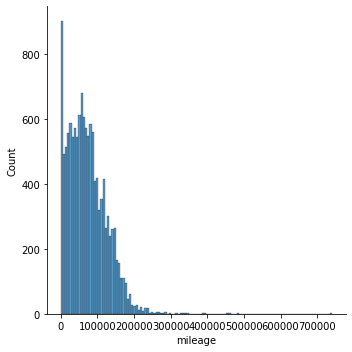

In [292]:
sns.displot(df_input["mileage"])

In [299]:
df_input[["mileage", "manufactured", "reg_date_year", "car_age"]].corr()

,mileage,manufactured,reg_date_year,car_age
mileage,1.000000,-0.702928,-0.744576,0.742959
manufactured,-0.702928,1.000000,0.925455,-0.924861
reg_date_year,-0.744576,0.925455,1.000000,-0.996098
car_age,0.742959,-0.924861,-0.996098,1.000000


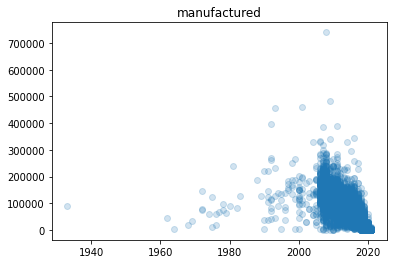

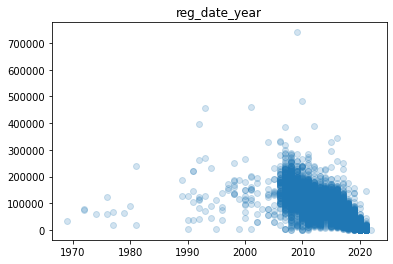

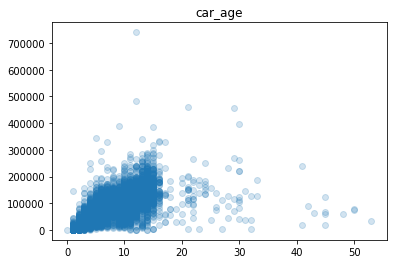

In [300]:
for i in ["manufactured", "reg_date_year", "car_age"]:
    plt.scatter(df_input[i], df_input["mileage"], alpha = 0.2)
    plt.title(i)
    plt.show()

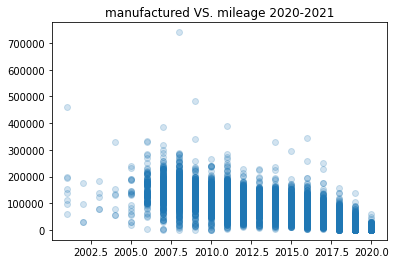

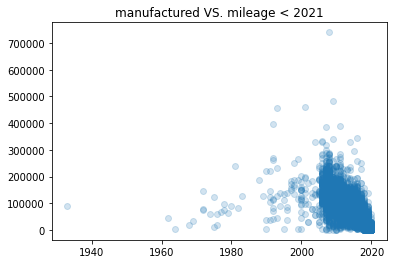

In [295]:
plt.scatter(df_input[(df_input["manufactured"] < 2021) & (df_input["manufactured"] > 2000)]["manufactured"], 
            df_input[(df_input["manufactured"] < 2021) & (df_input["manufactured"] > 2000)]["mileage"],
            alpha = 0.2)
plt.title("manufactured VS. mileage 2020-2021")
plt.show()

plt.scatter(df_input[(df_input["manufactured"] < 2021)]["manufactured"], 
            df_input[(df_input["manufactured"] < 2021)]["mileage"],
            alpha = 0.2)
plt.title("manufactured VS. mileage < 2021")
plt.show()

In [303]:
df_input["car_age"].isnull().sum()/len(df_input)

0.011975691134413727

In [304]:
#df_input[df_input["mileage"].isnull()]["manufactured"].value_counts()
df_manufactured_mileage_agg = df_input.groupby('car_age').agg({"mileage": ["mean"]}).reset_index()
df_manufactured_mileage_agg.columns = ['_'.join(col).strip() for col in df_manufactured_mileage_agg.columns.values]
df_manufactured_mileage_agg.rename(columns = {"car_age_": "car_age",
                                             "mileage": "mileage_mean"}, inplace=True)
df_manufactured_mileage_agg.to_csv("/Users/user/Desktop/cs5228_project_MARS/data/processed/manufactured_mileage_agg.csv")

In [305]:
df_input = df_input.merge(df_manufactured_mileage_agg[["car_age", "mileage_mean"]], on=["car_age"], how = 'left')
df_input["mileage_fill"] = np.where(df_input["mileage"].isnull(), 
                                    df_input["mileage_mean"] , 
                                    df_input["mileage"] )

In [306]:
print (df_input["mileage"].isnull().sum()/len(df_input))
print (df_input["mileage_fill"].isnull().sum()/len(df_input))

0.2218779790276454
0.0050643469971401334


In [307]:
df_input[['mileage_fill', 'mileage', 'price']].corr()

,mileage_fill,mileage,price
mileage_fill,1.000000,1.000000,-0.384715
mileage,1.000000,1.000000,-0.387148
price,-0.384715,-0.387148,1.000000
